In [11]:
import importlib
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from stk_search.geom3d import polymer_GNN_architecture_utils
from stk_search.utils import config_utils, update_datasets
from stk_search.utils.config_utils import read_config, save_config

%matplotlib inline

In [12]:
# Helper function to split the dataset


def check_building_block_present(df_total_path_new, config_dir):
    df_total = pd.read_csv(df_total_path_new, low_memory=False)
    config = read_config(config_dir)
    bbs_dict = polymer_GNN_architecture_utils.get_bbs_dict(
        config["pymongo_client"], config["precursor_database_name"]
    )
    bbs_dict
    # check df_total has inchikey in bb_dict
    for i in range(6):
        df_total = df_total[df_total[f"InChIKey_{i}"].isin(bbs_dict.keys())]
    df_total.to_csv(df_total_path_new, index=False)
    return df_total


def do_random_split(config, hide_best_molecules=True):
    df_path = Path(config["df_total"])
    if os.path.isfile(df_path):
        df = pd.read_csv(df_path, low_memory=False)
    else:
        print(
            "No dataframe found, will resort in a random split from the data in the database"
        )

    def topk_split(
        topkmol,
        df,
        num_molecules_dataset=5000,
        target_name="target",
        hide_best_molecules=hide_best_molecules,
    ):
        min_target_out_of_database = -np.sort(-df[target_name].values)[topkmol]
        df_test = df[df[target_name] >= min_target_out_of_database]
        if hide_best_molecules:
            df_train = df[df[target_name] < min_target_out_of_database]
        else:
            df_train = df.copy()
            print(df_train.shape[0])
        # add random element from df to the test set
        # df_test_random = df.sample(n=1000, random_state=1)
        # df_test = pd.concat([df_test, df_test_random])
        df_test.reset_index(drop=True, inplace=True)
        list_col = [f"InChIKey_{x}" for x in range(6)]
        list_col.append(target_name)
        list_col.append("InChIKey")
        df_train = df_train[list_col]
        df_train = df_train[~df_train["InChIKey"].isin(df_test["InChIKey"])]
        if num_molecules_dataset > df_train.shape[0]:
            print(
                "Warning: the number of molecules in the dataset is smaller than the number of molecules requested"
            )
            num_molecules_dataset = df_train.shape[0]
        df_train = df_train.sample(num_molecules_dataset)
        df_val = df_train.sample(frac=0.1, random_state=1)
        df_train = df_train[~df_train["InChIKey"].isin(df_val["InChIKey"])]
        df_train.reset_index(drop=True, inplace=True)
        df_val.reset_index(drop=True, inplace=True)
        return df_train, df_val, df_test

    topKmol = int(df.shape[0] * 0.01)
    df_train, df_val, df_test = topk_split(
        topKmol,
        df,
        config["num_molecules"],
        config["target_name"],
        hide_best_molecules=hide_best_molecules,
    )
    config_dir = config["running_dir"]
    df_train.to_csv(config_dir + "df_train.csv", index=False)
    df_val.to_csv(config_dir + "df_val.csv", index=False)
    df_test.to_csv(config_dir + "df_test.csv", index=False)
    for key in ["df_train", "df_val", "df_test"]:
        check_building_block_present(config_dir + key + ".csv", config_dir)
    return df_train, df_val, df_test

In [13]:
# load the database to learn from
df_total_path = "data_example/Molecule_database/30K_benchmark_150524.csv"
df_total = pd.read_csv(df_total_path, low_memory=False)
print(df_total.shape[0])
df_total.head()

30000


,InChIKey,InChIKey_0,InChIKey_1,InChIKey_2,InChIKey_3,InChIKey_4,InChIKey_5,num_BB,_id_x,Host IP_x,...,Excited state energy (eV),Excited state oscillator strength,Host IP_y,cal_folder_y,ES1,fosc1,target,2d_tani_pca_1,2d_tani_pca_2,PCA1
0,CLUOOVKTWZALSH-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,6.0,64d3e7f254f281add0b79e3b,129.31.64.208,...,"[3.994, 4.042, 4.08, 4.086, 4.117, 4.135, 4.53...","[0.1243, 0.153, 1.1697, 0.0908, 0.0574, 0.225,...",129.31.64.208,/media/storage-jelfscompute4/ma11115/Database_...,3.994,0.1243,-2.507029,-1.481492,-0.711649,-1.481492
1,FIAQXLPLTBETIQ-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,DNHRBCFMFYOUKM-UHFFFAOYSA-N,6.0,64d2671054f281add0ab9f7d,unknown,...,"[3.97, 3.993, 4.033, 4.048, 4.1, 4.468, 4.493,...","[0.1121, 0.7001, 0.151, 0.2114, 0.4041, 0.0137...",NaN,NaN,3.970,0.1121,-2.572794,-1.426185,-0.714994,-1.426185
2,BPPOMYWNHKZIDY-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,UANFRSYASSMVLC-UHFFFAOYSA-N,6.0,64d3d12454f281add0b6e27c,129.31.64.208,...,"[3.309, 3.524, 3.539, 3.801, 3.968, 4.022, 4.0...","[0.0925, 0.0002, 0.0114, 0.0521, 0.0396, 0.962...",129.31.64.208,/media/storage-jelfscompute4/ma11115/Database_...,3.309,0.0925,-2.049258,-1.211625,-0.677382,-1.211625
3,VHLADBSIMMJWOE-UHFFFAOYSA-N,UANFRSYASSMVLC-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,6.0,64d34e7654f281add0abce29,unknown,...,"[3.415, 3.456, 3.562, 3.583, 3.615, 3.646, 3.6...","[0.0005, 0.0009, 0.0036, 0.0078, 0.0043, 0.011...",NaN,NaN,3.415,0.0005,-4.742130,-0.877781,-1.337407,-0.877781
4,DUPCULAXVLTLBX-UHFFFAOYSA-N,GKKUHQQNQBVLSW-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,UANFRSYASSMVLC-UHFFFAOYSA-N,DNHRBCFMFYOUKM-UHFFFAOYSA-N,6.0,64d34ec654f281add0abcfc5,unknown,...,"[2.841, 3.339, 3.483, 3.544, 3.685, 3.857, 3.8...","[0.3302, 0.0721, 0.0038, 0.0144, 0.2322, 0.102...",NaN,NaN,2.841,0.3302,-1.628323,-1.224275,-0.606765,-1.224275


In [14]:
importlib.reload(update_datasets)
importlib.reload(config_utils)
config_dir_list = []
pymongo_client = "mongodb://localhost:27017/"
for num_molecules in [5000]:
    config = config_utils.generate_config(
        num_molecules=num_molecules,
        df_path=df_total_path,
        max_epochs=200,
        target_name="target",
        running_dir="data_example/representation_learning/",
    )
    config["pymongo_client"] = pymongo_client
    config["database_name"] = "stk_constructed"
    config["df_precursor"] = "data_example/precursor/df_properties.pkl"
    config["ephemeral_path"] = (
        "data_example/representation_learning/ephemeral/Random_split/"
    )
    config["max_epochs"] = 10
    config["precursor_database_name"] = "stk_precursor"
    config_dir = config["running_dir"]
    save_config(config, config_dir)
    if config["split_type"] == "rand":
        df_train, df_val, df_test = do_random_split(
            config, hide_best_molecules=True
        )

    config_dir_list.append(config_dir)

In [ ]:
# test script
config_dir = config_dir_list[0]
dev_scripts_dir = "/media/mohammed/Work/STK_search/src/dev_scripts/"
%run {dev_scripts_dir}/run_representation_learning_polymer.py --config_dir {config_dir}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mohammed-azzouzi15 (azzouzi_lab). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/media/mohammed/Work/anaconda3/envs/stk_search/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /media/mohammed/Work/STK_search/Example_notebooks/data_example/representation_learning/6-frag/target/241101/SchNet/splitrand-nummol5000 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params | Mode 
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/media/mohammed/Work/anaconda3/envs/stk_search/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/media/mohammed/Work/anaconda3/envs/stk_search/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/media/mohammed/Work/anaconda3/envs/stk_search/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
lr,██▇▇▆▄▃▂▂▁
train_loss,██▅▃▂▃▃▄▂▅▃▄▃▃▁▂▃▃▃▃▄▂▄▂▃▂▁▂▁▂▂▆▁▂▂▃▂▂▁▁
train_loss_repr,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_target,▆█▆▄▂▄▃▄▂▆▃▄▃▃▁▂▃▃▃▃▄▃▅▂▄▂▁▂▁▂▃▆▁▂▂▄▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▄▆▅▂▂▂▂▁
val_loss_repr,█▁▁▂▁▂▂▃▃▃
val_loss_target,█▆▄▆▅▂▂▂▂▁
epoch,9
lr,1e-05


Model loaded:  SchNet
Model loaded


## test representation


In [15]:
import importlib

from stk_search.geom3d import pl_model, train_models
from stk_search.Representation import Representation_poly_3d

importlib.reload(Representation_poly_3d)


def load_representation_model(config_dir):
    config = read_config(config_dir)
    chkpt_path = config["model_embedding_chkpt"]
    checkpoint = torch.load(chkpt_path, map_location=config["device"])
    model, graph_pred_linear = pl_model.model_setup(config)
    print("Model loaded: ", config["model_name"])
    # Pass the model and graph_pred_linear to the Pymodel constructor
    pymodel = pl_model.Pymodel_new(model, graph_pred_linear, config)
    # Load the state dictionary
    pymodel.load_state_dict(state_dict=checkpoint["state_dict"])
    pymodel.to(config["device"])
    representation = Representation_poly_3d.RepresentationPoly3d(
        pymodel,
        device="cpu",
        mongo_client=config["pymongo_client"],
        database=config["database_name"],
    )
    return representation, pymodel

In [16]:
# load the Representation and the model

importlib.reload(Representation_poly_3d)

# config_dir = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/representation_learning/6-frag/target/241101/SchNet/splitrand-nummol5000/"


config, min_val_loss = train_models.get_best_embedding_model(config_dir)

Representation, pymodel = load_representation_model(config_dir)

Model loaded:  SchNet


In [17]:
df_name = "train"
config = read_config(config_dir)
df = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_train = df.sample(1000)
df_elements_train = df_train[[f"InChIKey_{x}" for x in range(6)]]
df_name = "test"
df_test = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_test = df_test.sample(100)
df_elements_test = df_test[[f"InChIKey_{x}" for x in range(6)]]
df_name = "val"
df_val = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_val = df_val.sample(100)
df_elements_val = df_val[[f"InChIKey_{x}" for x in range(6)]]

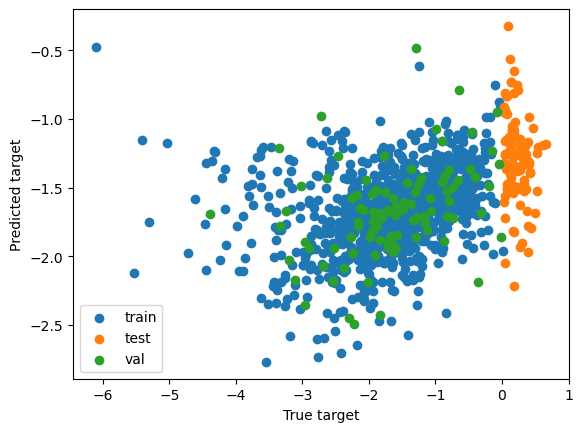

Training scores


In [18]:
def get_prediction_results(df_element):
    with torch.no_grad():
        X_rpr = Representation.generate_repr(df_element)
        Y_pred = pymodel.graph_pred_linear(X_rpr).flatten(0).detach()
    return Y_pred


Y_pred_train = get_prediction_results(df_elements_train)
Y_pred_test = get_prediction_results(df_elements_test)
Y_pred_val = get_prediction_results(df_elements_val)

Y_train = df_train["target"].values
Y_test = df_test["target"].values
Y_val = df_val["target"].values

fig, ax = plt.subplots()
ax.scatter(Y_train, Y_pred_train, label="train")
ax.scatter(Y_test, Y_pred_test, label="test")
ax.scatter(Y_val, Y_pred_val, label="val")
ax.set_xlabel("True target")
ax.set_ylabel("Predicted target")
ax.legend()
plt.show()
# print training scores
print("Training scores")

In [19]:
def get_scores(Y_pred, Y_true):
    from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error,
        r2_score,
    )

    mse = mean_squared_error(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    R2 = r2_score(Y_true, Y_pred)

    return mse, mae, R2


mse_train, mae_train, R2_train = get_scores(Y_pred_train, Y_train)
mse_test, mae_test, R2_test = get_scores(Y_pred_test, Y_test)
mse_val, mae_val, R2_val = get_scores(Y_pred_val, Y_val)
print(f"MSE train: {mse_train}, MAE train: {mae_train}, R2 train: {R2_train}")
print(f"MSE test: {mse_test}, MAE test: {mae_test}, R2 test: {R2_test}")
print(f"MSE val: {mse_val}, MAE val: {mae_val}, R2 val: {R2_val}")

MSE train: 0.6911514857669745, MAE train: 0.5986191336854195, R2 train: 0.09549660101148161
MSE test: 2.4508482028022924, MAE test: 1.5193170583702937, R2 test: -116.72768912302868
MSE val: 0.6044862754393554, MAE val: 0.5811728343268908, R2 val: 0.1336200122315605
